In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import trimesh
import os

# Our local modules
import src.calibrate as clb
import src.util as util

# Overview

We process and export rigid body data for the endoscope markers into a JSON file. This data will later be used to estimate the orientation of the endoscope and hence the camera on CT scans.

> **Note that we only need to run this code once in the beginning of the experiment.**

# Check that we're in the correct folder

For the code in this notebook to work correctly, the Jupyter server must be started from the `endoscope-calibration` folder. Then you put all of your data in the `./endoscope-calibration/data/`. 

In [2]:
# Check that we're in the right directory
base_dir_name = 'endoscope-calibration'
cwd = os.getcwd()
if not cwd.endswith(base_dir_name):
    print('[WARNING] Your base directory is not \'{}\' - are you running '
          'Jupyter in the correct server?'.format(base_dir_name))
    
data_dir = path.join(cwd, 'data')

# Load endscope marker meshes from calibration and phantom CT scans

In [3]:
endo_calib_dir = path.join(data_dir, 'endo_calib')
endo_phantom_dir = path.join(data_dir, 'endo_phantom')

endo_calib_markers_file = path.join(endo_calib_dir, 'mesh2_endoscope_markers.stl')
endo_phantom_markers_file = path.join(endo_phantom_dir, 'mesh1_endoscope_markers.stl')

endo_calib_markers_joint = trimesh.load(endo_calib_markers_file)
endo_phantom_markers_joint = trimesh.load(endo_phantom_markers_file)

# Extract and visualise marker centroids

We'll also go ahead and centre the calibration point cloud since we'll use it as a reference in the future.

<IPython.core.display.Javascript object>


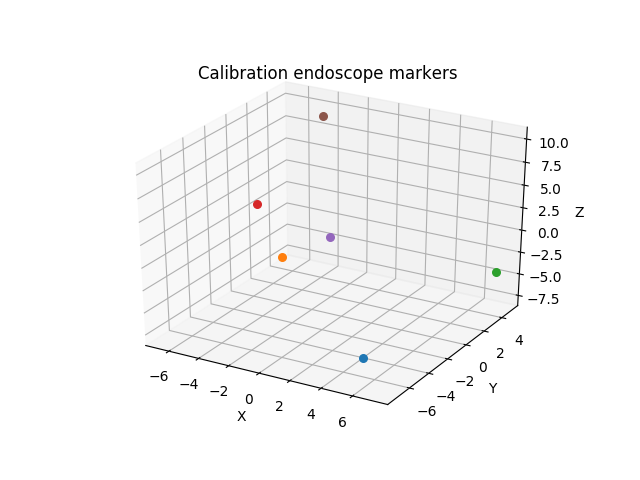

<IPython.core.display.Javascript object>


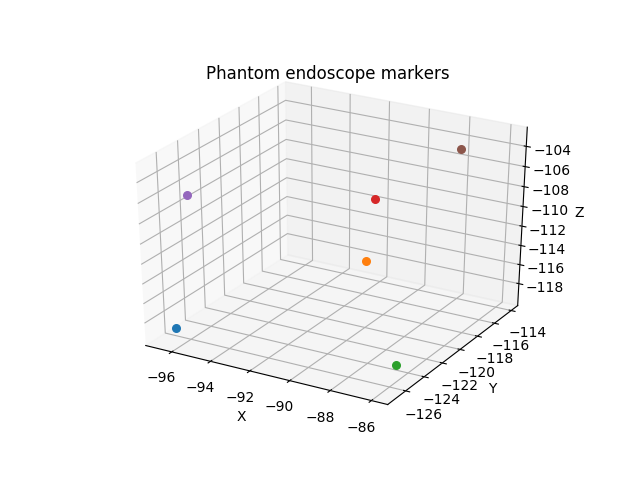

In [4]:
calib_centroids = util.extract_marker_mesh_centroids(endo_calib_markers_joint)
phantom_centroids = util.extract_marker_mesh_centroids(endo_phantom_markers_joint)

calib_points_3d = np.array(calib_centroids).T
calib_points_3d = (calib_points_3d.T - np.mean(calib_points_3d, axis=1)).T

phantom_points_3d = np.array(phantom_centroids).T

_, ax1 = util.prepare_3d_plot(title='Calibration endoscope markers')
util.draw_3d_points(ax1, calib_points_3d, size=30)
_, ax2 = util.prepare_3d_plot(title='Phantom endoscope markers')
util.draw_3d_points(ax2, phantom_points_3d, size=30)

# Figure out the correspondence and transformation between the two point clouds

In [5]:
T = clb.calc_rigid_body_transform(calib_points_3d, phantom_points_3d)

# Visualise the transformation

If the estimates are correct, the point clouds should be (almost) perfectly aligned.

<IPython.core.display.Javascript object>


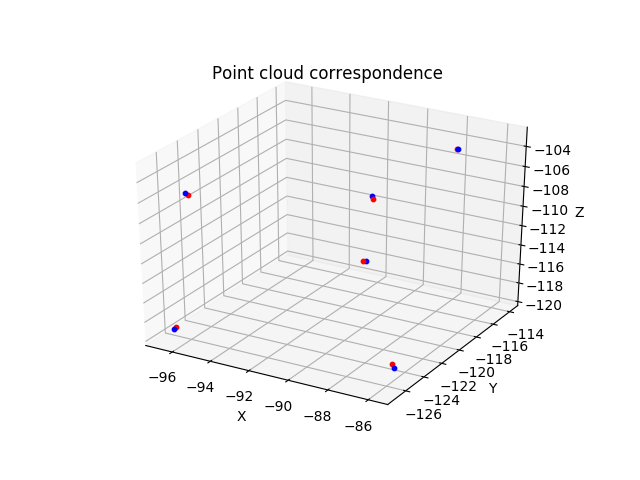

In [6]:
calib_transformed_points_3d = util.apply_transform(calib_points_3d, T)

points_viz = [
    (phantom_points_3d, 'red'),
    (calib_transformed_points_3d, 'blue'),
]

_, ax = util.prepare_3d_plot(title='Point cloud correspondence')
for points, colour in points_viz:
    util.draw_3d_points(ax, points, colour=colour)

# Store reference rigid body (as markers) into a JSON file

In [7]:
extrinsics_file = path.join(data_dir, 'extrinsics.json')
util.save_extrinsics(extrinsics_file, endoscope_markers=calib_points_3d)